# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.joe,
#    parameters=np.array([[2.5]]), rotation=90
#    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )


copula_pv = pv.Bicop(
    family=pv.BicopFamily.bb1,
    parameters=np.array([[1.2],[2.0]]),
    rotation=0
)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_61785/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_61785/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_61785/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_tes

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None
        )
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-19 15:39:09,976] A new study created in RDB with name: no-name-43d6cdac-9ce0-4c95-8735-69fad139395a
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<11:01,  3.02it/s]

current_loss: tensor(1.4535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4607627391815186
current_loss: tensor(1.4491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.441130518913269
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 6/2000 [00:00<02:48, 11.81it/s]

tensor(1.5862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4343211650848389
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4337188005447388
current_loss: tensor(1.4192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.433890461921692
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4338510036468506


  0%|          | 9/2000 [00:00<02:11, 15.14it/s]

current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4338093996047974
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4337618350982666
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4336570501327515
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4333499670028687
current_loss: tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<01:49, 18.17it/s]

current_loss: tensor(1.4173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4334396123886108
current_loss: tensor(1.4173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4332435131072998
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4331581592559814
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.433249592781067
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4329053163528442


  1%|          | 17/2000 [00:01<01:42, 19.43it/s]

current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4328187704086304
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4326924085617065
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4325231313705444
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.432448148727417
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<01:49, 18.08it/s]

current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4326997995376587
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4329558610916138
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4330201148986816
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:11, 15.07it/s]


current_loss_val:  1.433085322380066
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4331189393997192
Early Stop at iteration 23 with minimal loss tensor(1.4324, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<03:36,  9.23it/s]

current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.377458095550537
current_loss: tensor(1.3662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2052146196365356
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:39,  9.10it/s]

current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.17829430103302
current_loss: tensor(1.2005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1493395566940308
current_loss: tensor(1.1901, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.1801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.148855447769165
current_loss: tensor(1.1801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1500808000564575
current_loss: tensor(1.1764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1726, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:14, 10.23it/s]

current_loss_val:  1.1489567756652832
current_loss: tensor(1.1726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1693, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:11, 10.42it/s]

current_loss_val:  1.1488080024719238
current_loss: tensor(1.1693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1459780931472778
current_loss: tensor(1.1656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1338928937911987


  1%|          | 11/2000 [00:01<03:20,  9.90it/s]

current_loss: tensor(1.1486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.128119945526123
current_loss: tensor(1.1435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1259576082229614
current_loss: tensor(1.1394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0965098142623901


  1%|          | 14/2000 [00:01<04:36,  7.19it/s]

current_loss: tensor(1.1068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0676448345184326
current_loss: tensor(1.0855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0788, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<06:11,  5.35it/s]

current_loss_val:  1.0628689527511597
current_loss: tensor(1.0788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0770, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<06:51,  4.82it/s]

current_loss_val:  1.0611345767974854
current_loss: tensor(1.0770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0746, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<07:18,  4.53it/s]

current_loss_val:  1.0612859725952148
current_loss: tensor(1.0746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0968, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<08:35,  3.84it/s]

current_loss: tensor(1.0737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0589669942855835
current_loss: tensor(1.0737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0727, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<10:12,  3.23it/s]

current_loss_val:  1.058905839920044
current_loss: tensor(1.0727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:03<12:37,  2.61it/s]

current_loss_val:  1.0583961009979248
current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0688, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:04<15:49,  2.08it/s]

current_loss_val:  1.05963933467865
current_loss: tensor(1.0688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0675, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<18:12,  1.81it/s]

current_loss_val:  1.0592923164367676
current_loss: tensor(1.0675, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<17:59,  1.83it/s]

current_loss: tensor(1.0654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0587575435638428
current_loss: tensor(1.0654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0667, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<19:20,  1.70it/s]

current_loss: tensor(1.0639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0590022802352905
current_loss: tensor(1.0639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0642, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<20:40,  1.59it/s]

current_loss: tensor(1.0635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0574861764907837
current_loss: tensor(1.0635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<17:52,  1.84it/s]

current_loss_val:  1.057356357574463
current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<15:31,  2.12it/s]

current_loss: tensor(1.0610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0572694540023804
current_loss: tensor(1.0610, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:08<13:08,  2.50it/s]

current_loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0542418956756592
current_loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:08<11:35,  2.83it/s]

current_loss: tensor(1.0600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054919719696045
current_loss: tensor(1.0600, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:08<09:58,  3.29it/s]

current_loss: tensor(1.0598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552871227264404
current_loss: tensor(1.0598, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:08<09:17,  3.53it/s]

current_loss: tensor(1.0595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0549980401992798
current_loss: tensor(1.0595, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:09<09:35,  3.42it/s]

current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0558620691299438
current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0591, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:09<09:46,  3.35it/s]

current_loss_val:  1.0555881261825562
Early Stop at iteration 32 with minimal loss tensor(1.0542, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:39:24,149] Trial 0 finished with value: -2.1084837913513184 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.487989196221612, 'penalty_decorrelation_ridge_second_difference': 0.7223788132427809}. Best is trial 0 with value: -2.1084837913513184.
  0%|          | 1/2000 [00:00<04:15,  7.82it/s]

current_loss: tensor(1.0655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055126667022705
current_loss: tensor(1.0636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552234649658203


  0%|          | 4/2000 [00:00<03:42,  8.99it/s]

current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0553350448608398
current_loss: tensor(1.0611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0559266805648804


  0%|          | 6/2000 [00:00<03:22,  9.82it/s]

current_loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0558727979660034
current_loss: tensor(1.0603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054980993270874
current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:15, 10.20it/s]

current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0550041198730469
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0539878606796265
current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:11, 10.39it/s]

current_loss_val:  1.0540156364440918
current_loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0530025959014893
current_loss: tensor(1.0568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0530784130096436


  1%|          | 12/2000 [00:01<03:12, 10.31it/s]

current_loss: tensor(1.0565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053076148033142
current_loss: tensor(1.0561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.052270770072937


  1%|          | 14/2000 [00:01<03:18,  9.99it/s]

current_loss: tensor(1.0558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0526201725006104
current_loss: tensor(1.0555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0525810718536377
current_loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:14, 10.21it/s]

current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051196575164795
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0514856576919556
current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0535, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:08, 10.50it/s]

current_loss_val:  1.0510261058807373
current_loss: tensor(1.0535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.05000638961792
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0488017797470093


  1%|          | 22/2000 [00:02<03:07, 10.58it/s]

current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049149990081787
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0495492219924927
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:05, 10.63it/s]

current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0491682291030884
current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0473719835281372
current_loss: tensor(1.0474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:04, 10.68it/s]

current_loss_val:  1.0479559898376465
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0481618642807007
current_loss: tensor(1.0439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048162579536438


  1%|▏         | 28/2000 [00:02<03:17,  9.99it/s]

current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0480027198791504
current_loss: tensor(1.0432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0481464862823486
Early Stop at iteration 28 with minimal loss tensor(1.0474, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:39:27,572] Trial 1 finished with value: -2.0947437286376953 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.81600470451248, 'penalty_decorrelation_ridge_second_difference': 26.373905121040394}. Best is trial 1 with value: -2.0947437286376953.
  0%|          | 1/2000 [00:00<04:28,  7.46it/s]

current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0553630590438843
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:25,  9.70it/s]

current_loss_val:  1.0549770593643188
current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0545014142990112
current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054229497909546


  0%|          | 5/2000 [00:00<03:41,  8.99it/s]

current_loss: tensor(1.0530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0535337924957275
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0537128448486328


  0%|          | 7/2000 [00:00<03:24,  9.73it/s]

current_loss: tensor(1.0521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053168535232544
current_loss: tensor(1.0515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0511, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:25,  9.70it/s]

current_loss_val:  1.0518383979797363
current_loss: tensor(1.0511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0516879558563232
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0510497093200684


  1%|          | 11/2000 [00:01<03:24,  9.72it/s]

current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0505225658416748
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051620602607727
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:16, 10.10it/s]

current_loss: tensor(1.0494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050549864768982
current_loss: tensor(1.0494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050299048423767
current_loss: tensor(1.0494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:09, 10.48it/s]

current_loss_val:  1.0501614809036255
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050584077835083
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050251841545105


  1%|          | 19/2000 [00:01<03:07, 10.59it/s]

current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0504298210144043
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0508193969726562
current_loss: tensor(1.0486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:28,  9.48it/s]


current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0509908199310303
Early Stop at iteration 19 with minimal loss tensor(1.0502, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:39:30,132] Trial 2 finished with value: -2.1003224849700928 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.384063498639662, 'penalty_decorrelation_ridge_second_difference': 12.292318289368074}. Best is trial 1 with value: -2.0947437286376953.
  0%|          | 1/2000 [00:00<04:19,  7.70it/s]

current_loss: tensor(1.0592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0554430484771729
current_loss: tensor(1.0583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:39,  9.11it/s]

current_loss_val:  1.0551257133483887
current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0546621084213257
current_loss: tensor(1.0574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:57,  8.41it/s]

current_loss_val:  1.0547444820404053
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0538965463638306
current_loss: tensor(1.0558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0555, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:32,  9.39it/s]

current_loss_val:  1.0542668104171753
current_loss: tensor(1.0555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0542434453964233
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0517044067382812


  0%|          | 9/2000 [00:00<03:21,  9.90it/s]

current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0528792142868042
current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.052668809890747
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:15, 10.19it/s]

current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0522810220718384
current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0523146390914917
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:08, 10.51it/s]

current_loss_val:  1.0516308546066284
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051862359046936
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051925778388977


  1%|          | 17/2000 [00:01<03:07, 10.59it/s]

current_loss: tensor(1.0525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0513840913772583
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0519832372665405
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:06, 10.63it/s]

current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0515462160110474
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0506069660186768
current_loss: tensor(1.0508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:07, 10.53it/s]

current_loss_val:  1.0517181158065796
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0497920513153076
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0497921705245972


  1%|          | 23/2000 [00:02<03:07, 10.57it/s]

current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0485765933990479
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496399402618408


  1%|▏         | 25/2000 [00:02<03:25,  9.59it/s]

current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0471463203430176
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0464284420013428


  1%|▏         | 27/2000 [00:02<03:19,  9.88it/s]

current_loss: tensor(1.0403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0438274145126343
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0447636842727661
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:15, 10.10it/s]

current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04459810256958
current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0433510541915894
current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0363, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:21,  9.76it/s]

current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.042145013809204
current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0420571565628052
current_loss: tensor(1.0348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:18,  9.92it/s]

current_loss_val:  1.0419070720672607
current_loss: tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.041037917137146
current_loss: tensor(1.0340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0419988632202148


  2%|▏         | 37/2000 [00:03<03:14, 10.09it/s]

current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0411325693130493
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04094660282135
current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<03:20,  9.76it/s]

current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.041038155555725
current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0416152477264404
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:15, 10.02it/s]

current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0416067838668823
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0418932437896729
current_loss: tensor(1.0331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0356, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:23,  9.64it/s]


current_loss: tensor(1.0331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0415765047073364
Early Stop at iteration 41 with minimal loss tensor(1.0409, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:39:34,946] Trial 3 finished with value: -2.081892967224121 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.15850471525017, 'penalty_decorrelation_ridge_second_difference': 8.566036550389443}. Best is trial 3 with value: -2.081892967224121.
  0%|          | 1/2000 [00:00<04:24,  7.55it/s]

current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0551873445510864
current_loss: tensor(1.0496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:30,  9.49it/s]

current_loss_val:  1.0549142360687256
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054136037826538
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0533900260925293


  0%|          | 6/2000 [00:00<03:23,  9.81it/s]

current_loss: tensor(1.0483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049977421760559
current_loss: tensor(1.0477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0525407791137695


  0%|          | 7/2000 [00:00<03:27,  9.60it/s]

current_loss: tensor(1.0474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0509392023086548
current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0506936311721802
current_loss: tensor(1.0467, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:44,  8.88it/s]

current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.05057692527771
current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0512256622314453
Early Stop at iteration 9 with minimal loss tensor(1.0500, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:39:36,544] Trial 4 finished with value: -2.099954605102539 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.464729268855608, 'penalty_decorrelation_ridge_second_difference': 8.984425275889917}. Best is trial 3 with value: -2.081892967224121.
  0%|          | 1/2000 [00:00<04:15,  7.81it/s]

current_loss: tensor(1.0565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552265644073486
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0549719333648682


  0%|          | 4/2000 [00:00<03:42,  8.97it/s]

current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0545374155044556
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055219054222107


  0%|          | 6/2000 [00:00<03:23,  9.78it/s]

current_loss: tensor(1.0533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054542899131775
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0538383722305298
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:16, 10.12it/s]

current_loss: tensor(1.0519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0534420013427734
current_loss: tensor(1.0519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0520061254501343
current_loss: tensor(1.0514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0511, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:12, 10.32it/s]

current_loss_val:  1.0520689487457275
current_loss: tensor(1.0511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0516232252120972
current_loss: tensor(1.0506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0504, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:22,  9.84it/s]

current_loss_val:  1.0507549047470093
current_loss: tensor(1.0504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0508701801300049
current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0507928133010864


  1%|          | 14/2000 [00:01<03:17, 10.08it/s]

current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0502132177352905
current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050455093383789
current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:13, 10.24it/s]

current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050047755241394
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049582839012146
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:08, 10.49it/s]

current_loss_val:  1.0500800609588623
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048850178718567
current_loss: tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0485076904296875


  1%|          | 22/2000 [00:02<03:07, 10.57it/s]

current_loss: tensor(1.0481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0484189987182617
current_loss: tensor(1.0477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0487977266311646


  1%|          | 24/2000 [00:02<04:04,  8.07it/s]

current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0478037595748901
current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0483847856521606
current_loss: tensor(1.0461, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:46,  8.70it/s]

current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0485657453536987
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0483462810516357
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:51,  8.53it/s]

current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.047694444656372
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0479565858840942
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:25,  9.60it/s]

current_loss_val:  1.0481655597686768
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0473425388336182
current_loss: tensor(1.0439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0479295253753662


  2%|▏         | 33/2000 [00:03<03:18,  9.92it/s]

current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0480395555496216
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0475139617919922
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:14, 10.13it/s]

current_loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04717218875885
current_loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0473525524139404
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:11, 10.23it/s]

current_loss_val:  1.0471855401992798
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.047132968902588
current_loss: tensor(1.0422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0472407341003418


  2%|▏         | 39/2000 [00:03<03:09, 10.36it/s]

current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0467898845672607
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.047135829925537
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:15, 10.03it/s]

current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0472043752670288
current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0469629764556885
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:24,  9.57it/s]

current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04689359664917
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0468353033065796
Early Stop at iteration 43 with minimal loss tensor(1.0468, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:39:41,606] Trial 5 finished with value: -2.0935795307159424 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.22508172748394, 'penalty_decorrelation_ridge_second_difference': 20.713205305558024}. Best is trial 3 with value: -2.081892967224121.
  0%|          | 1/2000 [00:00<04:21,  7.65it/s]

current_loss: tensor(1.0672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0550891160964966
current_loss: tensor(1.0651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0645, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:29,  9.54it/s]

current_loss_val:  1.0552539825439453
current_loss: tensor(1.0645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0554066896438599
current_loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0619, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:15,  7.82it/s]

current_loss_val:  1.0561548471450806
current_loss: tensor(1.0619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.056144118309021
current_loss: tensor(1.0616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552388429641724
Early Stop at iteration 5 with minimal loss tensor(1.0551, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:39:42,837] Trial 6 finished with value: -2.110178232192993 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.81055554717301, 'penalty_decorrelation_ridge_second_difference': 28.120879293411484}. Best is trial 3 with value: -2.081892967224121.
  0%|          | 1/2000 [00:00<04:23,  7.60it/s]

current_loss: tensor(1.0658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0553040504455566
current_loss: tensor(1.0640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552271604537964


  0%|          | 3/2000 [00:00<03:27,  9.64it/s]

current_loss: tensor(1.0636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0568183660507202
current_loss: tensor(1.0617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0612, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:27,  9.63it/s]

current_loss_val:  1.0555899143218994
current_loss: tensor(1.0612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0555838346481323
current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0551238059997559


  0%|          | 8/2000 [00:00<03:19,  9.99it/s]

current_loss: tensor(1.0600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0545361042022705
current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0540663003921509
current_loss: tensor(1.0585, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:14, 10.22it/s]

current_loss: tensor(1.0576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0531903505325317
current_loss: tensor(1.0576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0544341802597046
current_loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0568, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:12, 10.34it/s]

current_loss_val:  1.0533840656280518
current_loss: tensor(1.0568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0530234575271606
current_loss: tensor(1.0566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053040862083435


  1%|          | 14/2000 [00:01<03:09, 10.48it/s]

current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0537500381469727
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0532580614089966
current_loss: tensor(1.0561, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:27,  9.57it/s]

current_loss: tensor(1.0560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053093671798706
current_loss: tensor(1.0560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0530509948730469
Early Stop at iteration 16 with minimal loss tensor(1.0530, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:39:45,058] Trial 7 finished with value: -2.1060469150543213 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.19602084688768, 'penalty_decorrelation_ridge_second_difference': 20.869855513421815}. Best is trial 3 with value: -2.081892967224121.
  0%|          | 1/2000 [00:00<04:20,  7.66it/s]

current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055026888847351
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0548017024993896


  0%|          | 3/2000 [00:00<03:25,  9.72it/s]

current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0525450706481934
current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.05133056640625
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:36,  9.19it/s]

current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0493535995483398
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0493049621582031
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:46,  8.81it/s]

current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0487644672393799
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0493061542510986


  0%|          | 10/2000 [00:01<03:32,  9.38it/s]

current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0489616394042969
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0479811429977417
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:35,  9.23it/s]

current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0477879047393799
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0469101667404175
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:25,  9.65it/s]

current_loss: tensor(1.0381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0467815399169922
current_loss: tensor(1.0381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0461150407791138
current_loss: tensor(1.0378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0378, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:35,  9.22it/s]

current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.046778678894043
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0462769269943237
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0366, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:18,  9.97it/s]

current_loss_val:  1.0450637340545654
current_loss: tensor(1.0366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0450206995010376
current_loss: tensor(1.0364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0437726974487305


  1%|          | 21/2000 [00:02<03:13, 10.21it/s]

current_loss: tensor(1.0363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0440962314605713
current_loss: tensor(1.0361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044477105140686
current_loss: tensor(1.0360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:21,  9.81it/s]

current_loss: tensor(1.0356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044511318206787
current_loss: tensor(1.0356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.043996810913086
current_loss: tensor(1.0356, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:37,  9.08it/s]


current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0440462827682495
Early Stop at iteration 23 with minimal loss tensor(1.0438, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:39:48,176] Trial 8 finished with value: -2.087545394897461 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3197622853747358, 'penalty_decorrelation_ridge_second_difference': 6.937533021074693}. Best is trial 3 with value: -2.081892967224121.
  0%|          | 1/2000 [00:00<04:26,  7.50it/s]

current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055146336555481
current_loss: tensor(1.0577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0574, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:28,  9.57it/s]

current_loss_val:  1.0550689697265625
current_loss: tensor(1.0574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055915355682373
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:30,  9.46it/s]

current_loss_val:  1.054803729057312
current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0547678470611572
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054059624671936


  0%|          | 7/2000 [00:00<03:28,  9.58it/s]

current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0537523031234741
current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053345799446106
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:19,  9.96it/s]

current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0528700351715088
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0512511730194092
current_loss: tensor(1.0525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:11, 10.38it/s]

current_loss_val:  1.0518368482589722
current_loss: tensor(1.0522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0520532131195068
current_loss: tensor(1.0521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0520867109298706


  1%|          | 14/2000 [00:01<03:33,  9.31it/s]


current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0520447492599487
current_loss: tensor(1.0519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0521676540374756
Early Stop at iteration 14 with minimal loss tensor(1.0513, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:39:50,304] Trial 9 finished with value: -2.1025021076202393 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.490400628516753, 'penalty_decorrelation_ridge_second_difference': 24.27032169699197}. Best is trial 3 with value: -2.081892967224121.
  0%|          | 1/2000 [00:00<04:24,  7.55it/s]

current_loss: tensor(1.0521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0550609827041626
current_loss: tensor(1.0506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054910659790039


  0%|          | 4/2000 [00:00<03:38,  9.13it/s]

current_loss: tensor(1.0504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0546456575393677
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0529721975326538


  0%|          | 6/2000 [00:00<03:22,  9.83it/s]

current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0534756183624268
current_loss: tensor(1.0483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0536696910858154
current_loss: tensor(1.0482, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.09it/s]

current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0535496473312378
current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0526639223098755
current_loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0477, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:13, 10.26it/s]

current_loss_val:  1.0528761148452759
current_loss: tensor(1.0477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0528807640075684
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0523803234100342


  1%|          | 12/2000 [00:01<03:11, 10.36it/s]

current_loss: tensor(1.0471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0504841804504395
current_loss: tensor(1.0469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051007866859436
current_loss: tensor(1.0462, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.0461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0509759187698364
current_loss: tensor(1.0461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0509122610092163
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:27,  9.54it/s]

current_loss_val:  1.0509854555130005
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0507949590682983
Early Stop at iteration 16 with minimal loss tensor(1.0505, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:39:52,840] Trial 10 finished with value: -2.1009681224823 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.03901209567704, 'penalty_decorrelation_ridge_second_difference': 26.070162757158}. Best is trial 3 with value: -2.081892967224121.
  0%|          | 1/2000 [00:00<04:29,  7.41it/s]

current_loss: tensor(1.0653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055188775062561
current_loss: tensor(1.0634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0630, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:32,  9.40it/s]

current_loss_val:  1.0552200078964233
current_loss: tensor(1.0630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0559585094451904
current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0604, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:30,  9.45it/s]

current_loss_val:  1.0556102991104126
current_loss: tensor(1.0604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0555931329727173
current_loss: tensor(1.0601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055026650428772


  0%|          | 8/2000 [00:00<03:21,  9.91it/s]

current_loss: tensor(1.0592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0542725324630737
current_loss: tensor(1.0585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0539664030075073
current_loss: tensor(1.0577, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:16, 10.12it/s]

current_loss: tensor(1.0571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053271770477295
current_loss: tensor(1.0571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0534515380859375
current_loss: tensor(1.0566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:14, 10.23it/s]

current_loss_val:  1.0530098676681519
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.052830457687378
current_loss: tensor(1.0560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.052298665046692


  1%|          | 14/2000 [00:01<03:10, 10.43it/s]

current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.052209496498108
current_loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0520347356796265
current_loss: tensor(1.0551, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:07, 10.56it/s]

current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0511454343795776
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0492146015167236
current_loss: tensor(1.0537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:08, 10.48it/s]

current_loss_val:  1.0501916408538818
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0502921342849731
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0502004623413086


  1%|          | 21/2000 [00:02<03:27,  9.54it/s]

current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0508379936218262
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050424337387085
Early Stop at iteration 21 with minimal loss tensor(1.0492, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:39:55,695] Trial 11 finished with value: -2.098428964614868 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.9159077833935, 'penalty_decorrelation_ridge_second_difference': 24.226341846605585}. Best is trial 3 with value: -2.081892967224121.
  0%|          | 1/2000 [00:00<04:25,  7.54it/s]

current_loss: tensor(1.0576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0553867816925049
current_loss: tensor(1.0565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0562, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:47,  8.78it/s]

current_loss_val:  1.0549962520599365
current_loss: tensor(1.0562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.05455482006073
current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0548341274261475


  0%|          | 5/2000 [00:00<03:23,  9.80it/s]

current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0534950494766235
current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0538827180862427
current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.07it/s]

current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054157018661499
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0538212060928345
current_loss: tensor(1.0534, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:19, 10.00it/s]

current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0526551008224487
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0529758930206299
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0525, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:12, 10.35it/s]

current_loss_val:  1.0526618957519531
current_loss: tensor(1.0525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0519487857818604
current_loss: tensor(1.0518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0506021976470947


  1%|          | 15/2000 [00:01<03:09, 10.46it/s]

current_loss: tensor(1.0514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0511447191238403
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0511828660964966
current_loss: tensor(1.0506, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:09, 10.47it/s]

current_loss: tensor(1.0503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0502822399139404
current_loss: tensor(1.0503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0504738092422485
current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:10, 10.41it/s]

current_loss_val:  1.0504367351531982
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0495539903640747
current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0498988628387451


  1%|          | 21/2000 [00:02<03:09, 10.46it/s]

current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0499612092971802
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0482373237609863
current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:07, 10.57it/s]

current_loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0491842031478882
current_loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0484700202941895
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0465, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:07, 10.52it/s]

current_loss_val:  1.047135353088379
current_loss: tensor(1.0465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0472625494003296
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.045760154724121


  1%|▏         | 29/2000 [00:02<03:07, 10.54it/s]

current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0458351373672485
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0451929569244385
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:07, 10.50it/s]

current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0431846380233765
current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0447254180908203
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:07, 10.50it/s]

current_loss_val:  1.0434831380844116
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0419814586639404
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.041694164276123


  2%|▏         | 35/2000 [00:03<03:07, 10.47it/s]

current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0408201217651367
current_loss: tensor(1.0349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.040550708770752
current_loss: tensor(1.0342, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:07, 10.48it/s]

current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.040317416191101
current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.040529489517212
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0331, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<03:05, 10.55it/s]

current_loss_val:  1.040296196937561
current_loss: tensor(1.0331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0406736135482788
current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.040241003036499


  2%|▏         | 43/2000 [00:04<03:04, 10.58it/s]

current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.040439486503601
current_loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0405627489089966
current_loss: tensor(1.0326, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:05, 10.55it/s]

current_loss: tensor(1.0324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0400216579437256
current_loss: tensor(1.0324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0401943922042847
current_loss: tensor(1.0322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<03:05, 10.52it/s]

current_loss_val:  1.0400958061218262
current_loss: tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0392627716064453
current_loss: tensor(1.0317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0401577949523926


  2%|▏         | 49/2000 [00:04<03:04, 10.56it/s]

current_loss: tensor(1.0315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0397095680236816
current_loss: tensor(1.0314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0396485328674316
current_loss: tensor(1.0314, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:05<03:11, 10.18it/s]

current_loss: tensor(1.0314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.039835810661316
current_loss: tensor(1.0314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.039535403251648
Early Stop at iteration 51 with minimal loss tensor(1.0393, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:40:01,351] Trial 12 finished with value: -2.0785253047943115 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.90426561939588, 'penalty_decorrelation_ridge_second_difference': 14.491304950018359}. Best is trial 12 with value: -2.0785253047943115.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<12:01,  2.77it/s]

current_loss_val:  1.0552114248275757
current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0605, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<10:33,  3.15it/s]

current_loss_val:  1.0551458597183228
current_loss: tensor(1.0605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:39,  3.45it/s]

current_loss_val:  1.0564180612564087
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:17,  3.23it/s]

current_loss: tensor(1.0583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552254915237427
current_loss: tensor(1.0583, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<10:02,  3.31it/s]

current_loss: tensor(1.0581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552046298980713
current_loss: 

  0%|          | 6/2000 [00:01<09:38,  3.45it/s]

tensor(1.0581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0546213388442993


  0%|          | 7/2000 [00:01<08:38,  3.84it/s]

current_loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0541481971740723
current_loss: tensor(1.0567, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:01,  4.13it/s]

current_loss: tensor(1.0561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053613305091858
current_loss: tensor(1.0561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<07:08,  4.65it/s]

current_loss_val:  1.053039312362671
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0525174140930176


  1%|          | 11/2000 [00:02<06:58,  4.75it/s]

current_loss: tensor(1.0547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.052554965019226
current_loss: tensor(1.0545, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<06:55,  4.79it/s]

current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0520613193511963
current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<06:45,  4.90it/s]

current_loss_val:  1.0524089336395264
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<05:46,  5.72it/s]

current_loss_val:  1.0517964363098145
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051437258720398
current_loss: tensor(1.0534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0512295961380005


  1%|          | 17/2000 [00:03<04:32,  7.27it/s]

current_loss: tensor(1.0530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0500082969665527
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050233006477356
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:03<03:49,  8.61it/s]

current_loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0495877265930176
current_loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048932433128357
current_loss: tensor(1.0505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:04<03:32,  9.29it/s]

current_loss_val:  1.0475244522094727
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.047758936882019
current_loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0481433868408203


  1%|          | 24/2000 [00:04<03:24,  9.68it/s]

current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0470972061157227
current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0463106632232666
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:04<03:17,  9.99it/s]

current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0452895164489746
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0453284978866577
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:04<03:15, 10.10it/s]

current_loss_val:  1.045356035232544
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0444031953811646
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:05<03:20,  9.84it/s]

current_loss_val:  1.0449119806289673
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0446189641952515
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0440778732299805


  2%|▏         | 34/2000 [00:05<03:13, 10.15it/s]

current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0440438985824585
current_loss: tensor(1.0360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0440773963928223
current_loss: tensor(1.0358, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<03:11, 10.25it/s]

current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.043739914894104
current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0449143648147583
current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0348, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<03:10, 10.32it/s]

current_loss_val:  1.0439962148666382
current_loss: tensor(1.0348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0438106060028076
current_loss: tensor(1.0347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0437754392623901


  2%|▏         | 39/2000 [00:05<04:57,  6.60it/s]


current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0441795587539673
Early Stop at iteration 39 with minimal loss tensor(1.0437, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:40:07,915] Trial 13 finished with value: -2.087479829788208 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.326281606841214, 'penalty_decorrelation_ridge_second_difference': 22.846881907359958}. Best is trial 12 with value: -2.0785253047943115.
  0%|          | 1/2000 [00:00<04:27,  7.48it/s]

current_loss: tensor(1.0463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055169701576233
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:30,  9.47it/s]

current_loss_val:  1.0547361373901367
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0540145635604858
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0528916120529175


  0%|          | 5/2000 [00:00<03:38,  9.14it/s]

current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0521358251571655
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:27,  9.62it/s]

current_loss_val:  1.0515093803405762
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0505727529525757
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:27,  9.58it/s]

current_loss_val:  1.0496996641159058
current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049670696258545
current_loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049431324005127


  1%|          | 12/2000 [00:01<03:20,  9.93it/s]

current_loss: tensor(1.0410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0488697290420532
current_loss: tensor(1.0408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049503207206726
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:16, 10.10it/s]

current_loss: tensor(1.0406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0490244626998901
current_loss: tensor(1.0406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0487911701202393
current_loss: tensor(1.0406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0405, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:13, 10.26it/s]

current_loss_val:  1.0487176179885864
current_loss: tensor(1.0405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049576997756958
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0489351749420166


  1%|          | 18/2000 [00:01<03:09, 10.44it/s]

current_loss: tensor(1.0403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0487030744552612
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048608660697937
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:09, 10.43it/s]

current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0488653182983398
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0485478639602661
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:11, 10.32it/s]

current_loss_val:  1.0484365224838257
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0485188961029053
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0480576753616333


  1%|▏         | 26/2000 [00:02<03:09, 10.44it/s]

current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0480986833572388
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0480667352676392
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:09, 10.43it/s]

current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0472769737243652
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0475693941116333
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:08, 10.43it/s]

current_loss_val:  1.0473250150680542
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0462278127670288
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0459628105163574
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<04:37,  7.09it/s]

current_loss_val:  1.0445681810379028
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<05:41,  5.76it/s]

current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.043149471282959
current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:04<05:08,  6.37it/s]

current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.041640043258667
current_loss: tensor(1.0366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0414416790008545
current_loss: tensor(1.0363, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<04:32,  7.19it/s]

current_loss: tensor(1.0357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0399839878082275
current_loss: tensor(1.0357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0404754877090454
current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<04:31,  7.24it/s]

current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0403026342391968
current_loss: tensor(1.0353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0401277542114258
current_loss: tensor(1.0350, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:51,  8.47it/s]

current_loss: tensor(1.0348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0399481058120728
current_loss: tensor(1.0348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0399794578552246
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0344, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:33,  9.15it/s]

current_loss_val:  1.039140224456787
current_loss: tensor(1.0344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0398365259170532
current_loss: tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0395418405532837


  2%|▏         | 45/2000 [00:05<03:24,  9.54it/s]

current_loss: tensor(1.0341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0391379594802856
current_loss: tensor(1.0340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0391582250595093
current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:05<03:18,  9.82it/s]

current_loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0395818948745728
current_loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0391924381256104
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:05<03:11, 10.16it/s]

current_loss_val:  1.0391110181808472
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0392744541168213
current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0390808582305908
current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:06<03:52,  8.39it/s]

current_loss_val:  1.0396015644073486
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0394344329833984
current_loss: tensor(1.0332, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:06<04:34,  7.08it/s]

current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0393126010894775
current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:06<04:37,  7.01it/s]

current_loss_val:  1.0400928258895874
current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:06<03:54,  8.31it/s]

current_loss_val:  1.0396158695220947
Early Stop at iteration 55 with minimal loss tensor(1.0391, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:40:15,393] Trial 14 finished with value: -2.0781617164611816 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.9031137075577815, 'penalty_decorrelation_ridge_second_difference': 20.404672951742075}. Best is trial 14 with value: -2.0781617164611816.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:57,  3.72it/s]

current_loss_val:  1.0552163124084473
current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0547666549682617


  0%|          | 3/2000 [00:00<06:48,  4.89it/s]

current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054154396057129
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0530802011489868
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:09,  6.45it/s]

current_loss: tensor(1.0471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0525412559509277
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0517512559890747
current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:14,  7.84it/s]

current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0507872104644775
current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0493831634521484
current_loss: tensor(1.0432, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:50,  8.62it/s]

current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0498844385147095
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0501512289047241
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:50,  6.84it/s]

current_loss_val:  1.0503644943237305
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04990553855896
current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0503648519515991
Early Stop at iteration 12 with minimal loss tensor(1.0494, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:40:17,701] Trial 15 finished with value: -2.0987660884857178 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.185080308973003, 'penalty_decorrelation_ridge_second_difference': 17.720375342061345}. Best is trial 14 with value: -2.0781617164611816.
  0%|          | 1/2000 [00:00<04:24,  7.56it/s]

current_loss: tensor(1.0503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0549278259277344
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:54,  8.52it/s]

current_loss_val:  1.0539202690124512
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0509964227676392
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:49,  8.69it/s]

current_loss_val:  1.051328182220459
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0510482788085938
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0499762296676636


  0%|          | 7/2000 [00:00<03:45,  8.84it/s]

current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0490479469299316
current_loss: tensor(1.0465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0462, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:45,  8.83it/s]

current_loss_val:  1.049019694328308
current_loss: tensor(1.0462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048388957977295
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:02,  8.22it/s]

current_loss_val:  1.0489972829818726
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048703908920288
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:52,  8.56it/s]

current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049375295639038
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0484288930892944
current_loss: tensor(1.0437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:32,  9.34it/s]

current_loss_val:  1.0477389097213745
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0475537776947021
current_loss: tensor(1.0432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:37,  9.10it/s]

current_loss_val:  1.0465251207351685
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0463664531707764
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0453962087631226


  1%|          | 19/2000 [00:02<03:39,  9.04it/s]

current_loss: tensor(1.0426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.046109914779663
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:41,  8.93it/s]

current_loss_val:  1.0441694259643555
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0426216125488281
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:41,  8.94it/s]

current_loss_val:  1.0431816577911377
current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0426956415176392
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0417121648788452


  1%|▏         | 25/2000 [00:02<03:40,  8.97it/s]

current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.040977120399475
current_loss: tensor(1.0374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0358, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<03:32,  9.28it/s]

current_loss_val:  1.0413333177566528
current_loss: tensor(1.0358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0415942668914795
current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0413103103637695


  1%|▏         | 29/2000 [00:03<03:49,  8.59it/s]


current_loss: tensor(1.0354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0419909954071045
current_loss: tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0418016910552979
Early Stop at iteration 29 with minimal loss tensor(1.0410, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:40:21,673] Trial 16 finished with value: -2.081954002380371 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.19969885483792, 'penalty_decorrelation_ridge_second_difference': 0.02281910533511322}. Best is trial 14 with value: -2.0781617164611816.
  0%|          | 1/2000 [00:00<04:33,  7.30it/s]

current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0550893545150757
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0547839403152466


  0%|          | 4/2000 [00:00<03:31,  9.44it/s]

current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0538148880004883
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053889513015747


  0%|          | 6/2000 [00:00<03:20,  9.96it/s]

current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0524851083755493
current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0519925355911255
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:15, 10.21it/s]

current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0518567562103271
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0507501363754272
current_loss: tensor(1.0426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:15, 10.19it/s]

current_loss_val:  1.0505568981170654
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0510326623916626
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0499439239501953


  1%|          | 12/2000 [00:01<03:14, 10.21it/s]

current_loss: tensor(1.0417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049820065498352
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0497841835021973
current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:14, 10.21it/s]

current_loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0491684675216675
current_loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0491206645965576
current_loss: tensor(1.0411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:10, 10.43it/s]

current_loss_val:  1.0484557151794434
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048361897468567
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0473592281341553


  1%|          | 20/2000 [00:01<03:13, 10.23it/s]

current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.046923041343689
current_loss: tensor(1.0403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0467692613601685


  1%|          | 22/2000 [00:02<03:12, 10.25it/s]

current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0459885597229004
current_loss: tensor(1.0400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.045894980430603
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:13, 10.21it/s]

current_loss: tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0456366539001465
current_loss: tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044429063796997
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<04:09,  7.93it/s]

current_loss_val:  1.0447441339492798
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0450963973999023
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<04:01,  8.17it/s]

current_loss_val:  1.0451687574386597
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044620156288147
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<03:37,  9.08it/s]


current_loss_val:  1.0447089672088623
Early Stop at iteration 28 with minimal loss tensor(1.0444, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:40:25,386] Trial 17 finished with value: -2.088858127593994 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.6628097512362228, 'penalty_decorrelation_ridge_second_difference': 24.261587421584274}. Best is trial 14 with value: -2.0781617164611816.
  0%|          | 1/2000 [00:00<04:24,  7.56it/s]

current_loss: tensor(1.0504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552663803100586
current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:27,  9.63it/s]

current_loss_val:  1.0548429489135742
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054300308227539
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0535045862197876


  0%|          | 5/2000 [00:00<03:47,  8.79it/s]

current_loss: tensor(1.0481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0528708696365356
current_loss: tensor(1.0474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:32,  9.38it/s]

current_loss_val:  1.0522444248199463
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0519535541534424
current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0499944686889648


  0%|          | 9/2000 [00:00<03:24,  9.75it/s]

current_loss: tensor(1.0463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0504790544509888
current_loss: tensor(1.0461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0506929159164429
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:19,  9.96it/s]

current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.05082106590271
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0504497289657593
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0456, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:42,  8.93it/s]

current_loss_val:  1.0510629415512085
Early Stop at iteration 12 with minimal loss tensor(1.0500, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:40:27,332] Trial 18 finished with value: -2.0999884605407715 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.713135795442614, 'penalty_decorrelation_ridge_second_difference': 14.9090668603222}. Best is trial 14 with value: -2.0781617164611816.
  0%|          | 1/2000 [00:00<04:22,  7.61it/s]

current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0550037622451782
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.37it/s]

current_loss_val:  1.0547962188720703
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053689956665039
current_loss: tensor(1.0431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0525848865509033


  0%|          | 5/2000 [00:00<03:27,  9.60it/s]

current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0515047311782837
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051133155822754
current_loss: tensor(1.0411, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:20,  9.95it/s]

current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0501315593719482
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0504541397094727
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:15, 10.19it/s]

current_loss_val:  1.0498251914978027
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0494886636734009
current_loss: tensor(1.0400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050087809562683


  1%|          | 13/2000 [00:01<03:12, 10.31it/s]

current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049316644668579
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0491116046905518
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:12, 10.31it/s]

current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048782467842102
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0494499206542969
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:13, 10.26it/s]

current_loss_val:  1.0485796928405762
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0483639240264893
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0484230518341064


  1%|          | 19/2000 [00:01<03:13, 10.24it/s]

current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0484648942947388
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0483509302139282
current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:14, 10.17it/s]

current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0482593774795532
current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0481598377227783
current_loss: tensor(1.0385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:12, 10.26it/s]

current_loss_val:  1.047818899154663
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0481427907943726
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0480122566223145


  1%|▏         | 27/2000 [00:02<03:08, 10.45it/s]

current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0478688478469849
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04794180393219
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:10, 10.33it/s]

current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0474778413772583
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04746413230896
current_loss: tensor(1.0374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:11, 10.28it/s]

current_loss_val:  1.046729326248169
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04679274559021
current_loss: tensor(1.0370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:10, 10.34it/s]

current_loss_val:  1.0460903644561768
current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0440285205841064
current_loss: tensor(1.0362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0426572561264038


  2%|▏         | 35/2000 [00:03<03:10, 10.33it/s]

current_loss: tensor(1.0357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0409609079360962
current_loss: tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0402628183364868
current_loss: tensor(1.0349, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:25,  9.55it/s]

current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0403791666030884
current_loss: tensor(1.0345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0395379066467285
current_loss: tensor(1.0341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0380829572677612
current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:22,  9.68it/s]

current_loss_val:  1.0377085208892822
current_loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.037757158279419
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.037888765335083


  2%|▏         | 43/2000 [00:04<03:33,  9.19it/s]

current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0384407043457031
current_loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0325, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:21,  9.69it/s]

current_loss_val:  1.0382888317108154
current_loss: tensor(1.0325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0383833646774292
Early Stop at iteration 44 with minimal loss tensor(1.0377, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:40:32,532] Trial 19 finished with value: -2.0754170417785645 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.17509952019292863, 'penalty_decorrelation_ridge_second_difference': 27.823714424860068}. Best is trial 19 with value: -2.0754170417785645.
  0%|          | 1/2000 [00:00<04:23,  7.60it/s]

current_loss: tensor(1.0505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054977297782898
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0549038648605347


  0%|          | 3/2000 [00:00<03:29,  9.53it/s]

current_loss: tensor(1.0487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054402232170105
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0469, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:28,  9.58it/s]

current_loss_val:  1.0535972118377686
current_loss: tensor(1.0469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053444504737854
current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0520364046096802


  0%|          | 8/2000 [00:00<03:19,  9.96it/s]

current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.052298903465271
current_loss: tensor(1.0455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0516767501831055
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:21,  9.85it/s]

current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051211953163147
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0512043237686157
current_loss: tensor(1.0447, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:16, 10.12it/s]

current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0510854721069336
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0509026050567627
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:22,  9.82it/s]

current_loss_val:  1.0506564378738403
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0504028797149658
current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<04:09,  7.95it/s]

current_loss_val:  1.0498604774475098
current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<05:49,  5.67it/s]

current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049441933631897
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<07:33,  4.37it/s]

current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0484404563903809


  1%|          | 18/2000 [00:02<08:06,  4.08it/s]

current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0483767986297607
current_loss: tensor(1.0431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<06:01,  5.47it/s]

current_loss_val:  1.0480791330337524
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.047561526298523
current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0473145246505737


  1%|          | 23/2000 [00:03<04:36,  7.15it/s]

current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0465418100357056
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0465086698532104
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:19,  7.60it/s]

current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0461485385894775
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.046384572982788


  1%|▏         | 27/2000 [00:03<03:53,  8.47it/s]

current_loss: tensor(1.0417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0459651947021484
current_loss: tensor(1.0415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0454474687576294
current_loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:39,  8.99it/s]

current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0452139377593994
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0452717542648315
current_loss: tensor(1.0408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<03:25,  9.57it/s]

current_loss_val:  1.0446341037750244
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0445424318313599
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0444819927215576


  2%|▏         | 34/2000 [00:04<03:24,  9.60it/s]

current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04414701461792
current_loss: tensor(1.0398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044448971748352


  2%|▏         | 36/2000 [00:04<03:28,  9.44it/s]

current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0443671941757202
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044267177581787


  2%|▏         | 38/2000 [00:04<03:20,  9.77it/s]

current_loss: tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044409990310669
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0439974069595337
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:17,  9.91it/s]

current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0441069602966309
current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0433787107467651
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:05<03:15, 10.03it/s]

current_loss_val:  1.044090747833252
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0434688329696655
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0430376529693604


  2%|▏         | 44/2000 [00:05<03:12, 10.18it/s]

current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.043353796005249
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.042801856994629
current_loss: tensor(1.0370, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:05<03:12, 10.13it/s]

current_loss: tensor(1.0370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0430214405059814
current_loss: tensor(1.0370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0433052778244019
current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0366, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:05<03:54,  8.31it/s]

current_loss_val:  1.0430045127868652
current_loss: tensor(1.0366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0432626008987427
current_loss: tensor(1.0365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0429069995880127
Early Stop at iteration 49 with minimal loss tensor(1.0428, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:40:39,173] Trial 20 finished with value: -2.0856034755706787 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.108903902473706, 'penalty_decorrelation_ridge_second_difference': 29.397154327913576}. Best is trial 19 with value: -2.0754170417785645.
  0%|          | 1/2000 [00:00<04:24,  7.56it/s]

current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0551012754440308
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.37it/s]

current_loss_val:  1.0547577142715454
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0538063049316406
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0533031225204468


  0%|          | 6/2000 [00:00<03:19, 10.01it/s]

current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0517871379852295
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051396131515503
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0506218671798706
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:00,  8.29it/s]

current_loss_val:  1.049597978591919
current_loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049965262413025
current_loss: tensor(1.0411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:45,  8.84it/s]

current_loss_val:  1.0498559474945068
current_loss: tensor(1.0410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0492143630981445
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496455430984497


  1%|          | 13/2000 [00:01<03:25,  9.66it/s]

current_loss: tensor(1.0406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049311637878418
current_loss: tensor(1.0405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04886794090271
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:21,  9.87it/s]

current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048614501953125
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049186110496521
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:19,  9.92it/s]

current_loss_val:  1.048285722732544
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048150897026062
current_loss: tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0481986999511719


  1%|          | 20/2000 [00:02<03:13, 10.24it/s]

current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0480928421020508
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0483781099319458
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:14, 10.19it/s]

current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048135757446289
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0479475259780884
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:12, 10.24it/s]

current_loss_val:  1.047898292541504
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048341155052185
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0478776693344116


  1%|▏         | 28/2000 [00:02<03:14, 10.16it/s]

current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0477403402328491
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0478501319885254


  2%|▏         | 30/2000 [00:03<03:19,  9.89it/s]

current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0478063821792603
current_loss: tensor(1.0385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0476508140563965


  2%|▏         | 32/2000 [00:03<03:17,  9.95it/s]

current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.04741370677948
current_loss: tensor(1.0381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0464903116226196
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:15, 10.04it/s]

current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.046748161315918
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0467612743377686
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:11, 10.26it/s]

current_loss_val:  1.046252727508545
current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0445895195007324
current_loss: tensor(1.0365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.043662428855896


  2%|▏         | 38/2000 [00:03<03:08, 10.43it/s]

current_loss: tensor(1.0359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0406394004821777
current_loss: tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0404505729675293
current_loss: tensor(1.0347, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:07, 10.44it/s]

current_loss: tensor(1.0345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0398284196853638
current_loss: tensor(1.0345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0390247106552124
current_loss: tensor(1.0341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0341, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:10, 10.26it/s]

current_loss_val:  1.0395578145980835
current_loss: tensor(1.0341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0389045476913452
current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:14, 10.07it/s]

current_loss_val:  1.038835048675537
current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0390784740447998
current_loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0393033027648926


  2%|▏         | 48/2000 [00:04<03:10, 10.22it/s]

current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0394726991653442
current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0400373935699463
current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:04<03:21,  9.70it/s]


current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0398130416870117
Early Stop at iteration 48 with minimal loss tensor(1.0388, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:40:44,828] Trial 21 finished with value: -2.077669858932495 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.4659602576890673, 'penalty_decorrelation_ridge_second_difference': 23.66969182653105}. Best is trial 19 with value: -2.0754170417785645.
  0%|          | 1/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552057027816772
current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:35,  9.26it/s]

current_loss_val:  1.0547354221343994
current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0540026426315308
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:48,  8.74it/s]

current_loss_val:  1.0526413917541504
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051480770111084
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:29,  9.50it/s]

current_loss_val:  1.0500987768173218
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496786832809448
current_loss: tensor(1.0400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0498026609420776


  0%|          | 9/2000 [00:00<03:21,  9.90it/s]

current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049007534980774
current_loss: tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048965573310852
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:18,  9.99it/s]

current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0482642650604248
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0489228963851929
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:17, 10.08it/s]

current_loss_val:  1.0485076904296875
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0483314990997314
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0483955144882202


  1%|          | 15/2000 [00:01<03:36,  9.18it/s]

current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0492444038391113
Early Stop at iteration 15 with minimal loss tensor(1.0483, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:40:47,133] Trial 22 finished with value: -2.0965282917022705 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.02503355382241254, 'penalty_decorrelation_ridge_second_difference': 16.427124384448298}. Best is trial 19 with value: -2.0754170417785645.
  0%|          | 1/2000 [00:00<07:28,  4.46it/s]

current_loss: tensor(1.0465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054977536201477
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:20,  7.65it/s]

current_loss_val:  1.0548179149627686
current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053971529006958
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051804780960083


  0%|          | 6/2000 [00:00<03:38,  9.14it/s]

current_loss: tensor(1.0432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0523196458816528
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0525779724121094
current_loss: tensor(1.0422, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:28,  9.56it/s]

current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0524553060531616
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0515720844268799
current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0417, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:23,  9.79it/s]

current_loss_val:  1.0518652200698853
current_loss: tensor(1.0417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051936388015747
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051800012588501


  1%|          | 12/2000 [00:01<03:18, 10.03it/s]

current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0509111881256104
current_loss: tensor(1.0411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0509188175201416
current_loss: tensor(1.0408, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:16, 10.10it/s]

current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0505110025405884
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0489684343338013
current_loss: tensor(1.0398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:10, 10.39it/s]

current_loss_val:  1.049575924873352
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0489184856414795
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0487747192382812


  1%|          | 20/2000 [00:02<03:16, 10.10it/s]

current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0487637519836426
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0489784479141235
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0486801862716675
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:26,  9.60it/s]

current_loss_val:  1.0487867593765259
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0487630367279053
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:35,  9.15it/s]

current_loss_val:  1.0490288734436035
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0489853620529175
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0488767623901367
Early Stop at iteration 25 with minimal loss tensor(1.0487, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:40:50,482] Trial 23 finished with value: -2.097360372543335 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5568168862578067, 'penalty_decorrelation_ridge_second_difference': 28.98573494732612}. Best is trial 19 with value: -2.0754170417785645.
  0%|          | 1/2000 [00:00<04:27,  7.46it/s]

current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0551742315292358
current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0548384189605713


  0%|          | 3/2000 [00:00<03:31,  9.45it/s]

current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0541404485702515
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0541987419128418
current_loss: tensor(1.0481, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:22,  9.83it/s]

current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0529118776321411
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0525991916656494
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0467, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.10it/s]

current_loss_val:  1.052579402923584
current_loss: tensor(1.0467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0512466430664062
current_loss: tensor(1.0463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0510048866271973


  0%|          | 10/2000 [00:01<03:14, 10.24it/s]

current_loss: tensor(1.0461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050927996635437
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0497413873672485
current_loss: tensor(1.0455, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:12, 10.33it/s]

current_loss: tensor(1.0454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0501011610031128
current_loss: tensor(1.0454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0503376722335815
current_loss: tensor(1.0453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:16, 10.12it/s]

current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0503315925598145
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0498381853103638
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:30,  9.42it/s]


current_loss_val:  1.050155520439148
Early Stop at iteration 15 with minimal loss tensor(1.0497, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:40:52,724] Trial 24 finished with value: -2.099482536315918 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.284201755702743, 'penalty_decorrelation_ridge_second_difference': 21.23048325384986}. Best is trial 19 with value: -2.0754170417785645.
  0%|          | 1/2000 [00:00<04:29,  7.41it/s]

current_loss: tensor(1.0456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0550867319107056


  0%|          | 2/2000 [00:00<07:33,  4.41it/s]

current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054746389389038
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0537195205688477
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:48,  6.91it/s]

current_loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0531853437423706
current_loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0516371726989746
current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:05,  8.12it/s]

current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0511983633041382
current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.05059814453125
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:27,  9.57it/s]

current_loss_val:  1.049410343170166
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049731731414795
current_loss: tensor(1.0403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0499839782714844


  1%|          | 12/2000 [00:01<03:19,  9.99it/s]

current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496890544891357
current_loss: tensor(1.0398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0494272708892822
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:13, 10.26it/s]

current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049371361732483
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0492805242538452
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:09, 10.46it/s]

current_loss_val:  1.0490353107452393
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0486336946487427
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0482566356658936


  1%|          | 18/2000 [00:01<03:09, 10.49it/s]

current_loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.047788381576538
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.046332836151123
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:08, 10.50it/s]

current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0469173192977905
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0470906496047974
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0378, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:34,  9.20it/s]

current_loss_val:  1.0471915006637573
current_loss: tensor(1.0378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0466328859329224
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0470681190490723
Early Stop at iteration 23 with minimal loss tensor(1.0463, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:40:55,843] Trial 25 finished with value: -2.092665433883667 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.23002698671149627, 'penalty_decorrelation_ridge_second_difference': 24.25340027497078}. Best is trial 19 with value: -2.0754170417785645.
  0%|          | 1/2000 [00:00<04:42,  7.08it/s]

current_loss: tensor(1.0458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0551687479019165
current_loss: tensor(1.0447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:30,  9.49it/s]

current_loss_val:  1.0547269582748413
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0539966821670532
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0527979135513306


  0%|          | 5/2000 [00:00<03:39,  9.09it/s]

current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0521395206451416
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051425814628601


  0%|          | 8/2000 [00:00<03:34,  9.30it/s]

current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0507453680038452
current_loss: tensor(1.0412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496641397476196


  0%|          | 10/2000 [00:01<03:26,  9.65it/s]

current_loss: tensor(1.0410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496498346328735
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496543645858765


  1%|          | 12/2000 [00:01<03:20,  9.94it/s]

current_loss: tensor(1.0406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0489981174468994
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0493648052215576
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:15, 10.14it/s]

current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049092411994934
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0486619472503662
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:13, 10.24it/s]

current_loss_val:  1.048378586769104
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0466866493225098
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.047086477279663


  1%|          | 18/2000 [00:01<03:11, 10.33it/s]

current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0471255779266357
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0460366010665894


  1%|          | 20/2000 [00:02<03:17, 10.05it/s]

current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0457305908203125
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0381, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:24,  9.67it/s]

current_loss_val:  1.044704556465149
current_loss: tensor(1.0381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.045022964477539
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:31,  9.33it/s]

current_loss_val:  1.0450704097747803
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044445276260376
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0375, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:40,  8.95it/s]

current_loss_val:  1.0447649955749512
current_loss: tensor(1.0375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0445435047149658
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:24,  9.66it/s]

current_loss_val:  1.043959379196167
current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044498085975647
current_loss: tensor(1.0365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0438286066055298


  2%|▏         | 30/2000 [00:03<03:15, 10.07it/s]

current_loss: tensor(1.0362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0433521270751953
current_loss: tensor(1.0360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0436184406280518
current_loss: tensor(1.0357, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:10, 10.32it/s]

current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0426143407821655
current_loss: tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0424227714538574
current_loss: tensor(1.0353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0349, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:04, 10.65it/s]

current_loss_val:  1.0424541234970093
current_loss: tensor(1.0349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.041345477104187
current_loss: tensor(1.0347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0412009954452515


  2%|▏         | 38/2000 [00:03<03:07, 10.46it/s]

current_loss: tensor(1.0345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0419329404830933
current_loss: tensor(1.0342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.040723443031311
current_loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:19,  9.82it/s]

current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.040606141090393
current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0407309532165527
current_loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:22,  9.67it/s]

current_loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0405241250991821
current_loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0405222177505493
current_loss: tensor(1.0336, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:21,  9.74it/s]

current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0408285856246948
current_loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0404818058013916
current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<03:11, 10.20it/s]

current_loss_val:  1.040442943572998
current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0405921936035156
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.040384292602539


  2%|▏         | 49/2000 [00:04<03:11, 10.17it/s]

current_loss: tensor(1.0332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0403707027435303
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0395331382751465


  3%|▎         | 51/2000 [00:05<03:11, 10.16it/s]

current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0398248434066772
current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0399593114852905
current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:05<03:22,  9.60it/s]

current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0398794412612915
current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0395652055740356
current_loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:05<03:21,  9.65it/s]


current_loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.039631724357605
Early Stop at iteration 53 with minimal loss tensor(1.0395, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:41:02,068] Trial 26 finished with value: -2.079066514968872 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2307925504981578, 'penalty_decorrelation_ridge_second_difference': 20.374747005024197}. Best is trial 19 with value: -2.0754170417785645.
  0%|          | 1/2000 [00:00<04:17,  7.76it/s]

current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0550355911254883
current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055001974105835


  0%|          | 3/2000 [00:00<03:23,  9.80it/s]

current_loss: tensor(1.0537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0549365282058716
current_loss: tensor(1.0522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0518, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:28,  9.57it/s]

current_loss_val:  1.0544177293777466
current_loss: tensor(1.0518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0543291568756104
current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0532898902893066


  0%|          | 7/2000 [00:00<03:30,  9.45it/s]

current_loss: tensor(1.0508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0530991554260254
current_loss: tensor(1.0503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0523979663848877


  0%|          | 10/2000 [00:01<03:27,  9.59it/s]

current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0517488718032837
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0508006811141968


  1%|          | 12/2000 [00:01<03:20,  9.93it/s]

current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0511406660079956
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0513114929199219
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:13, 10.27it/s]

current_loss: tensor(1.0487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0511902570724487
current_loss: tensor(1.0487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050920009613037
current_loss: tensor(1.0486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:36,  9.17it/s]


current_loss_val:  1.0510410070419312
Early Stop at iteration 14 with minimal loss tensor(1.0508, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:41:04,372] Trial 27 finished with value: -2.1016011238098145 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.657491612644403, 'penalty_decorrelation_ridge_second_difference': 27.725669369997245}. Best is trial 19 with value: -2.0754170417785645.
  0%|          | 1/2000 [00:00<04:19,  7.70it/s]

current_loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055169939994812
current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0547971725463867


  0%|          | 3/2000 [00:00<03:35,  9.28it/s]

current_loss: tensor(1.0478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054084062576294
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0535868406295776
current_loss: tensor(1.0463, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:41,  9.01it/s]

current_loss: tensor(1.0458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0520840883255005
current_loss: tensor(1.0458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0521137714385986


  0%|          | 8/2000 [00:00<03:42,  8.97it/s]

current_loss: tensor(1.0453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0516701936721802
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0500301122665405


  0%|          | 10/2000 [00:01<03:27,  9.57it/s]

current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050565242767334
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0505361557006836
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:27,  9.59it/s]

current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496975183486938
current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0502907037734985
current_loss: tensor(1.0437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:17, 10.06it/s]

current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0499507188796997
current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049649953842163
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:16, 10.08it/s]

current_loss_val:  1.0496654510498047
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0495699644088745
current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:15, 10.11it/s]

current_loss_val:  1.0495328903198242
current_loss: tensor(1.0431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0490654706954956
current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0495965480804443


  1%|          | 21/2000 [00:02<03:13, 10.23it/s]

current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0494991540908813
current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0492688417434692
current_loss: tensor(1.0426, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:09, 10.43it/s]

current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0493526458740234
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0489299297332764
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0422, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:06, 10.57it/s]

current_loss_val:  1.049048662185669
current_loss: tensor(1.0422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049039602279663
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0480772256851196


  1%|▏         | 27/2000 [00:02<03:13, 10.19it/s]

current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0484027862548828
current_loss: tensor(1.0415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.047783613204956
current_loss: tensor(1.0412, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:19,  9.86it/s]

current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.046592116355896
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.046539545059204
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:16, 10.03it/s]

current_loss: tensor(1.0400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.045211911201477
current_loss: tensor(1.0400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0443341732025146
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:29,  9.39it/s]

current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0443906784057617
current_loss: tensor(1.0394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.043297290802002
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:21,  9.76it/s]

current_loss_val:  1.0422171354293823
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0417680740356445
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0396926403045654


  2%|▏         | 39/2000 [00:03<03:15, 10.04it/s]

current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.040229082107544
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0406990051269531
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:12, 10.19it/s]

current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0410268306732178
current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.041969656944275
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0375, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:23,  9.64it/s]


current_loss_val:  1.041724681854248
Early Stop at iteration 41 with minimal loss tensor(1.0397, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 15:41:09,261] Trial 28 finished with value: -2.079385280609131 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.8308774919995106, 'penalty_decorrelation_ridge_second_difference': 21.002466327202775}. Best is trial 19 with value: -2.0754170417785645.
  0%|          | 1/2000 [00:00<04:12,  7.93it/s]

current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.05508553981781
current_loss: tensor(1.0487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0548510551452637


  0%|          | 4/2000 [00:00<03:41,  9.03it/s]

current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054050087928772
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0547268390655518


  0%|          | 5/2000 [00:00<03:41,  9.02it/s]

current_loss: tensor(1.0471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0532317161560059
current_loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0528424978256226


  0%|          | 8/2000 [00:00<03:28,  9.55it/s]

current_loss: tensor(1.0462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0526230335235596
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0521987676620483


  0%|          | 9/2000 [00:00<03:27,  9.61it/s]

current_loss: tensor(1.0456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0517820119857788
current_loss: tensor(1.0454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0512990951538086


  1%|          | 11/2000 [00:01<03:23,  9.80it/s]

current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0499314069747925
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0505183935165405
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:14, 10.20it/s]

current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050426959991455
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0503240823745728
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:41,  8.95it/s]

current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.05059814453125
current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0501478910446167
Early Stop at iteration 15 with minimal loss tensor(1.0499, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 15:41:11,563] Trial 29 finished with value: -2.099862813949585 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.4274091060603755, 'penalty_decorrelation_ridge_second_difference': 24.761267407021812}. Best is trial 19 with value: -2.0754170417785645.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:47, 20.91it/s]

current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:42, 23.54it/s]

current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:38, 25.94it/s]

current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:38, 25.77it/s]

current_loss: tensor(1.4173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:36, 26.90it/s]

current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:35, 27.64it/s]

current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:34, 28.16it/s]

current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:00<00:34, 28.51it/s]

current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:00<00:33, 28.74it/s]

current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:35, 27.65it/s]

current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:35, 27.02it/s]

current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:43, 22.26it/s]

current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:39, 24.03it/s]

current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  4%|▍         | 42/1000 [00:01<00:54, 17.55it/s]

current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  4%|▍         | 45/1000 [00:02<01:24, 11.31it/s]

current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▍         | 46/1000 [00:02<00:53, 17.81it/s]

current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 46 with minimal loss tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3777002096176147


  0%|          | 2/1000 [00:00<01:32, 10.78it/s]

current_loss: tensor(1.3679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2213518619537354
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.188583254814148


  0%|          | 4/1000 [00:00<01:42,  9.74it/s]

current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1771936416625977
current_loss: tensor(1.2004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1697, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:42,  9.71it/s]

current_loss_val:  1.157291293144226
current_loss: tensor(1.1697, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<01:41,  9.75it/s]

current_loss: tensor(1.1614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1474839448928833
current_loss: tensor(1.1614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1430541276931763
current_loss: tensor(1.1512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1452, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<01:38, 10.11it/s]

current_loss_val:  1.1383882761001587
current_loss: tensor(1.1452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1269264221191406
current_loss: tensor(1.1342, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<01:35, 10.33it/s]

current_loss: tensor(1.1244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1042287349700928
current_loss: tensor(1.1244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1032007932662964
current_loss: tensor(1.1129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1084, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:01<01:34, 10.45it/s]

current_loss_val:  1.099719762802124
current_loss: tensor(1.1084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0952033996582031
current_loss: tensor(1.1017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0947, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:33, 10.52it/s]

current_loss_val:  1.0865614414215088
current_loss: tensor(1.0947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0870, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:01<01:33, 10.57it/s]

current_loss_val:  1.0805225372314453
current_loss: tensor(1.0870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0802172422409058
current_loss: tensor(1.0843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0800381898880005


  2%|▏         | 18/1000 [00:01<01:32, 10.59it/s]

current_loss: tensor(1.0808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.076932668685913
current_loss: tensor(1.0776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0762006044387817
current_loss: tensor(1.0752, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<01:32, 10.55it/s]

current_loss: tensor(1.0725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0727436542510986
current_loss: tensor(1.0725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0693086385726929
current_loss: tensor(1.0685, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:02<01:39,  9.84it/s]

current_loss: tensor(1.0657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0662153959274292
current_loss: tensor(1.0657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0654016733169556
current_loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0589, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:02<01:37, 10.04it/s]

current_loss_val:  1.0648479461669922
current_loss: tensor(1.0589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.063642144203186
current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:02<01:36, 10.11it/s]

current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.063433289527893
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0627641677856445
current_loss: tensor(1.0558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:02<01:34, 10.27it/s]

current_loss_val:  1.0593070983886719
current_loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0567041635513306
current_loss: tensor(1.0508, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:02<01:33, 10.36it/s]

current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0550405979156494
current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0554866790771484
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:03<01:32, 10.45it/s]

current_loss_val:  1.0556209087371826
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055236577987671


  3%|▎         | 34/1000 [00:03<01:31, 10.50it/s]

current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0554358959197998
current_loss: tensor(1.0482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0548362731933594
current_loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:03<01:31, 10.54it/s]

current_loss: tensor(1.0478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054831624031067
current_loss: tensor(1.0478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054731011390686
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:03<01:31, 10.56it/s]

current_loss_val:  1.053879976272583
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0539989471435547
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:03<01:30, 10.55it/s]

current_loss: tensor(1.0467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053512692451477
current_loss: tensor(1.0467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0524704456329346
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0465, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:04<01:35, 10.04it/s]

current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0528591871261597
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0523930788040161
current_loss: tensor(1.0455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0453, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:04<01:33, 10.22it/s]

current_loss_val:  1.052075982093811
current_loss: tensor(1.0453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.05204176902771
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:04<01:32, 10.35it/s]

current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0508618354797363
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0506064891815186
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:04<01:31, 10.44it/s]

current_loss_val:  1.048807144165039
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496267080307007


  5%|▌         | 50/1000 [00:04<01:30, 10.55it/s]

current_loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0478758811950684
current_loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0472002029418945
current_loss: tensor(1.0423, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:05<01:29, 10.61it/s]

current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0468558073043823
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0469664335250854
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0408, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:05<01:28, 10.65it/s]

current_loss_val:  1.046081781387329
current_loss: tensor(1.0408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0464723110198975
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:05<01:28, 10.71it/s]

current_loss: tensor(1.0403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0466973781585693
current_loss: tensor(1.0403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.046694040298462
current_loss: tensor(1.0402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:05<01:29, 10.58it/s]

current_loss_val:  1.046325445175171
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:05<01:32, 10.21it/s]

current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0466303825378418
Early Stop at iteration 58 with minimal loss tensor(1.0461, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
 

In [20]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6,
                sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =1.0,
                tau_vi_sigma_init = 0.15,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 20,   # used if conv_use_ema=False
                conv_tol = 0.01,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


  0%|          | 1/800 [00:09<2:04:36,  9.36s/it]


Iteration [1/800] train=6.9261    val_ELPD=-0.0405  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.50
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.15539  τ₁≈4.3336  τ₂≈8.6071  |  (EB targets) τ₄*≈0.53468  τ₁*≈118.65  τ₂*≈163.33
E_qf_total≈37.3991  E_qf1≈0.3096  E_qf2≈0.3033
[monitor] τ₄·E_qf≈5.81  target≈20.00 | τ₁·E_qf1≈1.34  target≈36.74 | τ₂·E_qf2≈2.61  target≈49.53
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 2/800 [00:13<1:26:03,  6.47s/it]


Iteration [2/800] train=6.9222    val_ELPD=-0.0388  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.53
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.12377  τ₁≈3.613  τ₂≈7.1063  |  (EB targets) τ₄*≈0.5373  τ₁*≈117.72  τ₂*≈164.24
E_qf_total≈37.2171  E_qf1≈0.3153  E_qf2≈0.3005
[monitor] τ₄·E_qf≈4.61  target≈20.00 | τ₁·E_qf1≈1.14  target≈37.11 | τ₂·E_qf2≈2.14  target≈49.35
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 3/800 [00:18<1:14:42,  5.62s/it]


Iteration [3/800] train=6.8922    val_ELPD=-0.0374  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.55
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.10114  τ₁≈3.167  τ₂≈6.0306  |  (EB targets) τ₄*≈0.53957  τ₁*≈114.97  τ₂*≈163.37
E_qf_total≈37.0600  E_qf1≈0.3324  E_qf2≈0.3031
[monitor] τ₄·E_qf≈3.75  target≈20.00 | τ₁·E_qf1≈1.05  target≈38.21 | τ₂·E_qf2≈1.83  target≈49.53
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 4/800 [00:28<1:35:24,  7.19s/it]


Iteration [4/800] train=6.9438    val_ELPD=-0.0363  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.57
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.084021  τ₁≈2.8895  τ₂≈5.2937  |  (EB targets) τ₄*≈0.54139  τ₁*≈112.62  τ₂*≈162.87
E_qf_total≈36.9359  E_qf1≈0.3477  E_qf2≈0.3047
[monitor] τ₄·E_qf≈3.10  target≈20.00 | τ₁·E_qf1≈1.00  target≈39.15 | τ₂·E_qf2≈1.61  target≈49.63
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 5/800 [00:32<1:21:59,  6.19s/it]


Iteration [5/800] train=7.0837    val_ELPD=-0.0354  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.60
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.070667  τ₁≈2.7201  τ₂≈4.7968  |  (EB targets) τ₄*≈0.54321  τ₁*≈111.95  τ₂*≈164.83
E_qf_total≈36.8119  E_qf1≈0.3521  E_qf2≈0.2987
[monitor] τ₄·E_qf≈2.60  target≈20.00 | τ₁·E_qf1≈0.96  target≈39.42 | τ₂·E_qf2≈1.43  target≈49.23
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 6/800 [00:36<1:13:53,  5.58s/it]


Iteration [6/800] train=7.1816    val_ELPD=-0.0348  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.62
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.060282  τ₁≈2.6061  τ₂≈4.4309  |  (EB targets) τ₄*≈0.54454  τ₁*≈109.06  τ₂*≈159.76
E_qf_total≈36.7219  E_qf1≈0.3720  E_qf2≈0.3145
[monitor] τ₄·E_qf≈2.21  target≈20.00 | τ₁·E_qf1≈0.97  target≈40.57 | τ₂·E_qf2≈1.39  target≈50.25
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 7/800 [00:41<1:09:41,  5.27s/it]


Iteration [7/800] train=7.2758    val_ELPD=-0.0343  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.65
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.052007  τ₁≈2.5293  τ₂≈4.1424  |  (EB targets) τ₄*≈0.54555  τ₁*≈108.23  τ₂*≈160.83
E_qf_total≈36.6540  E_qf1≈0.3779  E_qf2≈0.3111
[monitor] τ₄·E_qf≈1.91  target≈20.00 | τ₁·E_qf1≈0.96  target≈40.91 | τ₂·E_qf2≈1.29  target≈50.03
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 8/800 [00:46<1:06:38,  5.05s/it]


Iteration [8/800] train=7.3981    val_ELPD=-0.0340  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.68
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.045279  τ₁≈2.4631  τ₂≈3.9902  |  (EB targets) τ₄*≈0.54653  τ₁*≈108.02  τ₂*≈161.93
E_qf_total≈36.5881  E_qf1≈0.3795  E_qf2≈0.3076
[monitor] τ₄·E_qf≈1.66  target≈20.00 | τ₁·E_qf1≈0.93  target≈40.99 | τ₂·E_qf2≈1.23  target≈49.81
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 9/800 [00:50<1:05:56,  5.00s/it]


Iteration [9/800] train=7.5293    val_ELPD=-0.0335  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.70
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.039713  τ₁≈2.4606  τ₂≈3.8841  |  (EB targets) τ₄*≈0.54686  τ₁*≈107.8  τ₂*≈162.89
E_qf_total≈36.5658  E_qf1≈0.3811  E_qf2≈0.3046
[monitor] τ₄·E_qf≈1.45  target≈20.00 | τ₁·E_qf1≈0.94  target≈41.08 | τ₂·E_qf2≈1.18  target≈49.62
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|▏         | 10/800 [00:55<1:03:33,  4.83s/it]


Iteration [10/800] train=7.7916    val_ELPD=-0.0332  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.73
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.034913  τ₁≈2.4511  τ₂≈3.7737  |  (EB targets) τ₄*≈0.54761  τ₁*≈107.13  τ₂*≈160.68
E_qf_total≈36.5160  E_qf1≈0.3859  E_qf2≈0.3116
[monitor] τ₄·E_qf≈1.27  target≈20.00 | τ₁·E_qf1≈0.95  target≈41.35 | τ₂·E_qf2≈1.18  target≈50.06
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|▏         | 11/800 [00:59<1:01:51,  4.70s/it]


Iteration [11/800] train=7.8031    val_ELPD=-0.0328  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.75
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.030967  τ₁≈2.4444  τ₂≈3.6933  |  (EB targets) τ₄*≈0.54783  τ₁*≈107.1  τ₂*≈161.31
E_qf_total≈36.5014  E_qf1≈0.3861  E_qf2≈0.3096
[monitor] τ₄·E_qf≈1.13  target≈20.00 | τ₁·E_qf1≈0.94  target≈41.36 | τ₂·E_qf2≈1.14  target≈49.94
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 12/800 [01:04<1:00:36,  4.62s/it]


Iteration [12/800] train=7.9528    val_ELPD=-0.0328  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.78
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.027552  τ₁≈2.4259  τ₂≈3.6796  |  (EB targets) τ₄*≈0.54797  τ₁*≈107.12  τ₂*≈162.25
E_qf_total≈36.4921  E_qf1≈0.3860  E_qf2≈0.3066
[monitor] τ₄·E_qf≈1.01  target≈20.00 | τ₁·E_qf1≈0.94  target≈41.35 | τ₂·E_qf2≈1.13  target≈49.75
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 13/800 [01:09<1:02:39,  4.78s/it]


Iteration [13/800] train=8.0619    val_ELPD=-0.0325  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.80
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.024613  τ₁≈2.4074  τ₂≈3.636  |  (EB targets) τ₄*≈0.54802  τ₁*≈106.75  τ₂*≈160.03
E_qf_total≈36.4889  E_qf1≈0.3888  E_qf2≈0.3137
[monitor] τ₄·E_qf≈0.90  target≈20.00 | τ₁·E_qf1≈0.94  target≈41.50 | τ₂·E_qf2≈1.14  target≈50.19
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 14/800 [01:13<1:01:06,  4.67s/it]


Iteration [14/800] train=8.2061    val_ELPD=-0.0323  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.82
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.022048  τ₁≈2.3771  τ₂≈3.5958  |  (EB targets) τ₄*≈0.54793  τ₁*≈107.03  τ₂*≈160.67
E_qf_total≈36.4945  E_qf1≈0.3867  E_qf2≈0.3116
[monitor] τ₄·E_qf≈0.80  target≈20.00 | τ₁·E_qf1≈0.92  target≈41.39 | τ₂·E_qf2≈1.12  target≈50.07
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 15/800 [01:18<59:56,  4.58s/it]  


Iteration [15/800] train=8.3592    val_ELPD=-0.0321  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.85
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.019834  τ₁≈2.384  τ₂≈3.6107  |  (EB targets) τ₄*≈0.54758  τ₁*≈106.71  τ₂*≈160.49
E_qf_total≈36.5177  E_qf1≈0.3891  E_qf2≈0.3122
[monitor] τ₄·E_qf≈0.72  target≈20.00 | τ₁·E_qf1≈0.93  target≈41.52 | τ₂·E_qf2≈1.13  target≈50.10
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 16/800 [01:22<59:07,  4.52s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 17/800 [01:26<58:30,  4.48s/it]


Iteration [17/800] train=8.6560    val_ELPD=-0.0319  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.90
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.016155  τ₁≈2.3637  τ₂≈3.563  |  (EB targets) τ₄*≈0.54697  τ₁*≈107.64  τ₂*≈162.24
E_qf_total≈36.5590  E_qf1≈0.3822  E_qf2≈0.3067
[monitor] τ₄·E_qf≈0.59  target≈20.00 | τ₁·E_qf1≈0.90  target≈41.14 | τ₂·E_qf2≈1.09  target≈49.75
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 18/800 [01:31<58:01,  4.45s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 19/800 [01:35<57:46,  4.44s/it]


Iteration [19/800] train=8.9670    val_ELPD=-0.0316  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.95
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.013261  τ₁≈2.4002  τ₂≈3.6092  |  (EB targets) τ₄*≈0.54542  τ₁*≈107.46  τ₂*≈161.28
E_qf_total≈36.6624  E_qf1≈0.3836  E_qf2≈0.3097
[monitor] τ₄·E_qf≈0.49  target≈20.00 | τ₁·E_qf1≈0.92  target≈41.22 | τ₂·E_qf2≈1.12  target≈49.94
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▎         | 20/800 [01:40<57:31,  4.42s/it]


Iteration [20/800] train=9.0770    val_ELPD=-0.0315  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.97
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.012052  τ₁≈2.4001  τ₂≈3.5766  |  (EB targets) τ₄*≈0.54472  τ₁*≈107.01  τ₂*≈160.67
E_qf_total≈36.7095  E_qf1≈0.3868  E_qf2≈0.3116
[monitor] τ₄·E_qf≈0.44  target≈20.00 | τ₁·E_qf1≈0.93  target≈41.39 | τ₂·E_qf2≈1.11  target≈50.07
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 21/800 [01:44<57:27,  4.43s/it]

NOT IMPROVED! Nr. 1


  3%|▎         | 22/800 [01:48<57:15,  4.42s/it]


Iteration [22/800] train=9.2016    val_ELPD=-0.0314  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0099895  τ₁≈2.4191  τ₂≈3.6462  |  (EB targets) τ₄*≈0.54284  τ₁*≈108.4  τ₂*≈161.99
E_qf_total≈36.8372  E_qf1≈0.3767  E_qf2≈0.3074
[monitor] τ₄·E_qf≈0.37  target≈20.00 | τ₁·E_qf1≈0.91  target≈40.84 | τ₂·E_qf2≈1.12  target≈49.80
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 23/800 [01:53<57:03,  4.41s/it]

NOT IMPROVED! Nr. 1


  3%|▎         | 24/800 [01:59<1:04:10,  4.96s/it]

NOT IMPROVED! Nr. 2


  3%|▎         | 25/800 [02:03<1:01:50,  4.79s/it]


Iteration [25/800] train=9.1604    val_ELPD=-0.0312  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0075814  τ₁≈2.4431  τ₂≈3.519  |  (EB targets) τ₄*≈0.5391  τ₁*≈107.88  τ₂*≈160.35
E_qf_total≈37.0927  E_qf1≈0.3805  E_qf2≈0.3126
[monitor] τ₄·E_qf≈0.28  target≈20.00 | τ₁·E_qf1≈0.93  target≈41.05 | τ₂·E_qf2≈1.10  target≈50.13
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 26/800 [02:08<1:00:15,  4.67s/it]


Iteration [26/800] train=9.1263    val_ELPD=-0.0312  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0069208  τ₁≈2.381  τ₂≈3.5473  |  (EB targets) τ₄*≈0.53776  τ₁*≈108.62  τ₂*≈162.6
E_qf_total≈37.1850  E_qf1≈0.3752  E_qf2≈0.3055
[monitor] τ₄·E_qf≈0.26  target≈20.00 | τ₁·E_qf1≈0.89  target≈40.75 | τ₂·E_qf2≈1.08  target≈49.68
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 27/800 [02:12<59:07,  4.59s/it]  


Iteration [27/800] train=9.0971    val_ELPD=-0.0311  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.006323  τ₁≈2.4231  τ₂≈3.5186  |  (EB targets) τ₄*≈0.53621  τ₁*≈107.66  τ₂*≈159.56
E_qf_total≈37.2922  E_qf1≈0.3821  E_qf2≈0.3152
[monitor] τ₄·E_qf≈0.24  target≈20.00 | τ₁·E_qf1≈0.93  target≈41.14 | τ₂·E_qf2≈1.11  target≈50.29
 ELPD trend → IMPROVED! Congrats (0/10)


  4%|▎         | 28/800 [02:17<58:16,  4.53s/it]

NOT IMPROVED! Nr. 1


  4%|▎         | 29/800 [02:21<57:39,  4.49s/it]

NOT IMPROVED! Nr. 2


  4%|▍         | 30/800 [02:25<57:11,  4.46s/it]


Iteration [30/800] train=9.0248    val_ELPD=-0.0310  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0048189  τ₁≈2.4465  τ₂≈3.6245  |  (EB targets) τ₄*≈0.53099  τ₁*≈108.18  τ₂*≈160.85
E_qf_total≈37.6595  E_qf1≈0.3784  E_qf2≈0.3110
[monitor] τ₄·E_qf≈0.18  target≈20.00 | τ₁·E_qf1≈0.93  target≈40.93 | τ₂·E_qf2≈1.13  target≈50.03
 ELPD trend → IMPROVED! Congrats (0/10)


  4%|▍         | 31/800 [02:30<56:55,  4.44s/it]


Iteration [31/800] train=8.8973    val_ELPD=-0.0310  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0530 σmin=0.0528 σmax=0.0530  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0044014  τ₁≈2.3555  τ₂≈3.5495  |  (EB targets) τ₄*≈0.5293  τ₁*≈105.38  τ₂*≈154.23
E_qf_total≈37.7799  E_qf1≈0.3990  E_qf2≈0.3330
[monitor] τ₄·E_qf≈0.17  target≈20.00 | τ₁·E_qf1≈0.94  target≈42.05 | τ₂·E_qf2≈1.18  target≈51.35
 ELPD trend → IMPROVED! Congrats (0/10)


  4%|▍         | 32/800 [02:34<56:42,  4.43s/it]

NOT IMPROVED! Nr. 1


  4%|▍         | 33/800 [02:39<56:32,  4.42s/it]

NOT IMPROVED! Nr. 2


  4%|▍         | 34/800 [02:43<56:23,  4.42s/it]

NOT IMPROVED! Nr. 3


  4%|▍         | 35/800 [02:47<56:15,  4.41s/it]

NOT IMPROVED! Nr. 4

Iteration [35/800] train=7.9446    val_ELPD=-0.0314  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0658 σmin=0.0644 σmax=0.0659  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0030561  τ₁≈2.0446  τ₂≈2.7757  |  (EB targets) τ₄*≈0.52294  τ₁*≈85.654  τ₂*≈115.29
E_qf_total≈38.2389  E_qf1≈0.5830  E_qf2≈0.5130
[monitor] τ₄·E_qf≈0.12  target≈20.00 | τ₁·E_qf1≈1.19  target≈49.94 | τ₂·E_qf2≈1.42  target≈59.14
 ELPD trend → NOT improved! (4/10)


  4%|▍         | 36/800 [02:52<56:09,  4.41s/it]

NOT IMPROVED! Nr. 5


  5%|▍         | 37/800 [02:56<56:05,  4.41s/it]

NOT IMPROVED! Nr. 6


  5%|▍         | 38/800 [03:01<57:12,  4.50s/it]

NOT IMPROVED! Nr. 7


  5%|▍         | 39/800 [03:07<1:01:07,  4.82s/it]

NOT IMPROVED! Nr. 8


  5%|▌         | 40/800 [03:15<1:14:08,  5.85s/it]

NOT IMPROVED! Nr. 9

Iteration [40/800] train=6.8298    val_ELPD=-0.0315  S_train=8 S_val=32  lr=[0.00075, 0.000525, 0.0011250000000000001]  σ̄=0.0820 σmin=0.0779 σmax=0.0824  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0021048  τ₁≈1.6332  τ₂≈2.0512  |  (EB targets) τ₄*≈0.51473  τ₁*≈65.377  τ₂*≈81.551
E_qf_total≈38.8493  E_qf1≈0.8879  E_qf2≈0.8080
[monitor] τ₄·E_qf≈0.08  target≈20.00 | τ₁·E_qf1≈1.45  target≈58.05 | τ₂·E_qf2≈1.66  target≈65.89
 ELPD trend → NOT improved! (9/10)


  5%|▌         | 40/800 [03:25<1:05:06,  5.14s/it]

NOT IMPROVED! Nr. 10
Early stop @ epoch 41: no val improvement for 10 epochs.


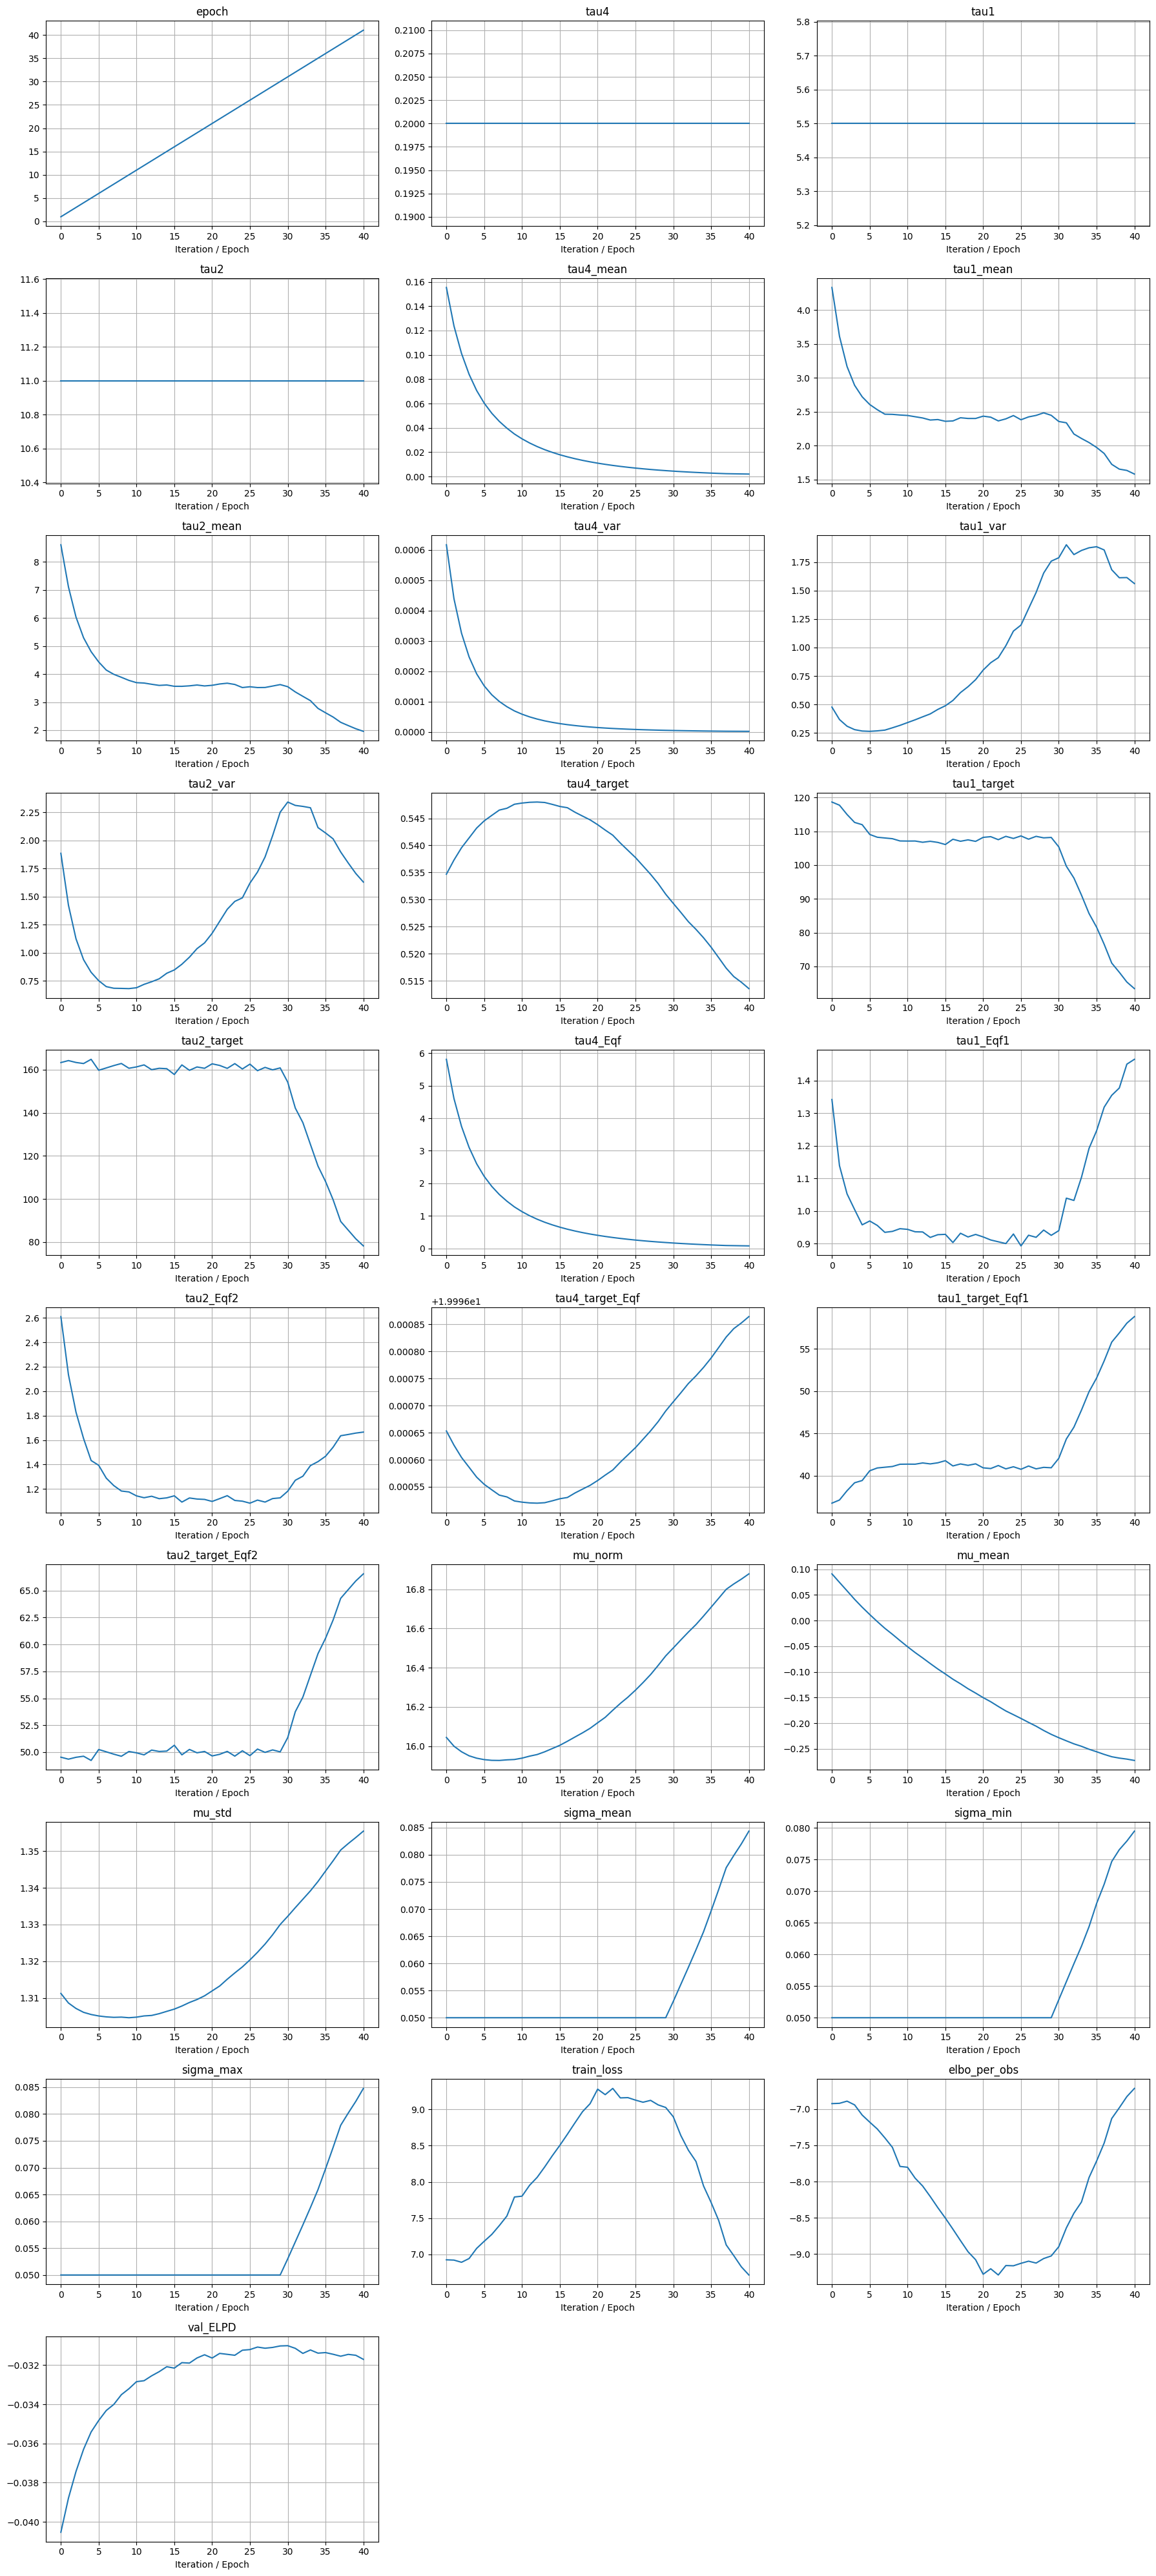

In [21]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

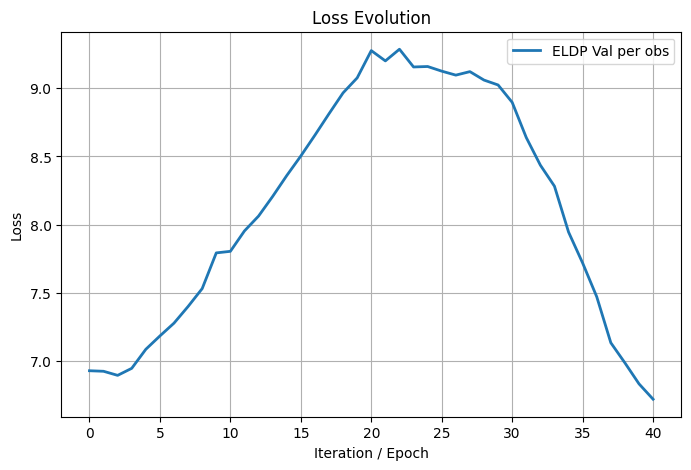

In [22]:

loss_history = output['loss_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [23]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [24]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [25]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM       Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian  Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula    Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM       Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian  Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula    Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.059
KLD GTM       Train Data:  0.0318
KLD Gaussian  Train Data:  0.0335
KLD Copula    Train Data:  0.7947

KLD BGTM      Test  Data:  0.0656
KLD GTM       Test  Data:  0.0365
KLD Gaussian  Test  Data:  0.0402
KLD Copula    Test  Data:  0.7959


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [26]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

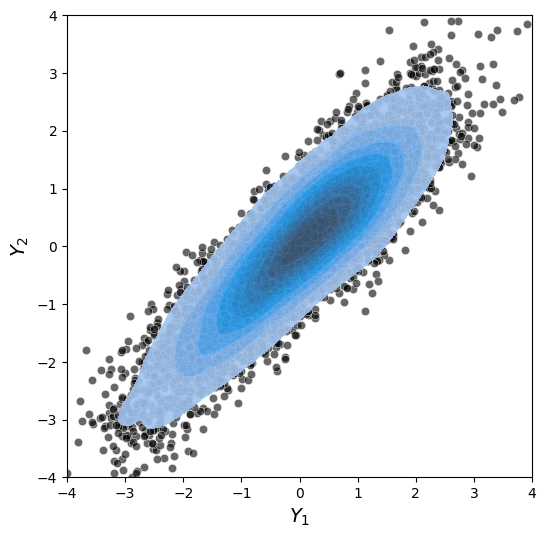

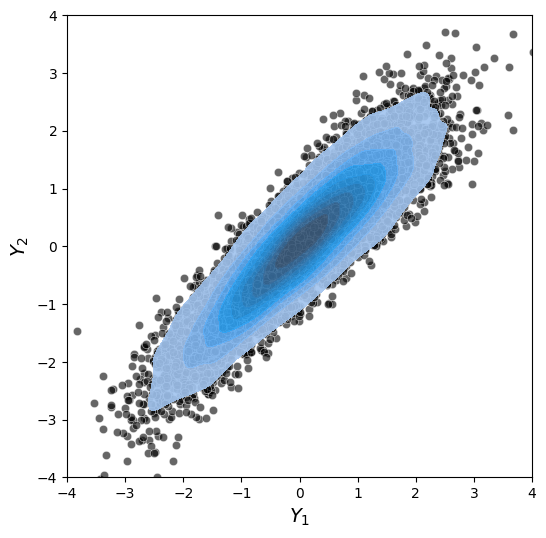

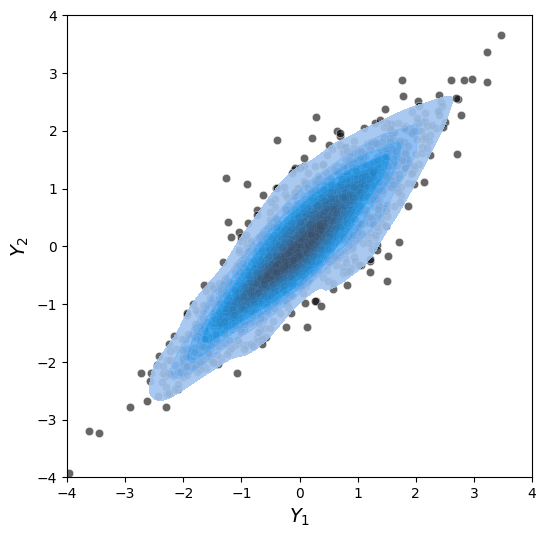

In [27]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [18]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [19]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


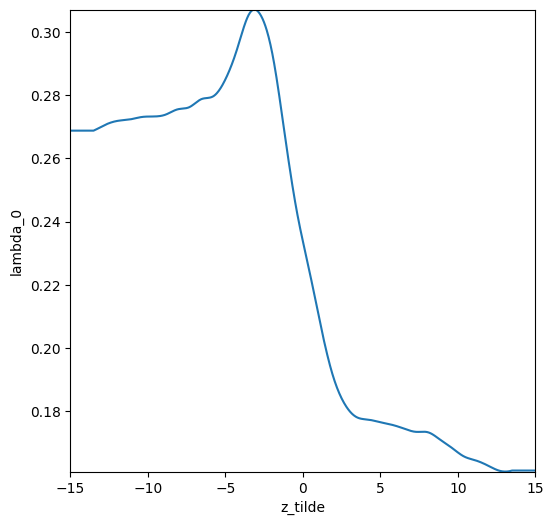

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


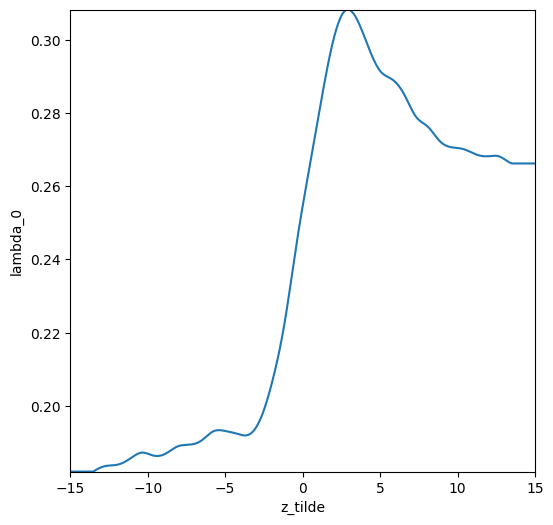

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


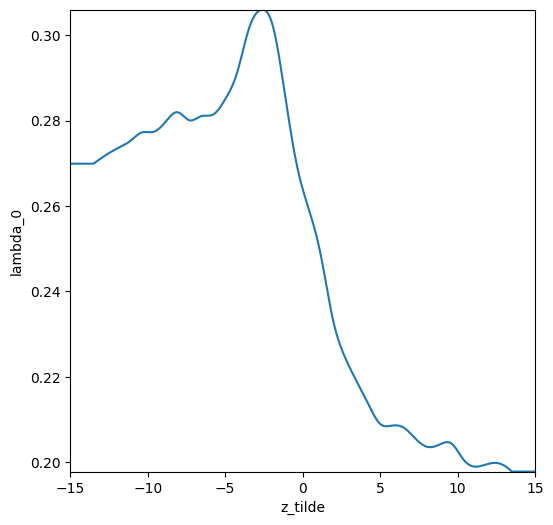

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)